# Chapter 5.1 - Text Classification with Logistic Regression

Our first machine-learning challenge is to create a prediction model that categorizes news articles with the appropriate categories from a set of 31 categories: politics, entertainment, etc. The model uses logistic regression techniques in Python on a dataset with headlines, short descriptions, and URLs. 

*NOTE*: Be sure to watch and read the materials posted in the Canvas module before and while you work through this notebook.

**Learning Objectives**

1. Import and run EDA techniques to understand the potential limits and affordances of the dataset with our ML goal in mind.
2. Learn about the basic mechanics of logistic regression (LR).
3. Apply LR to this text classification goal of categorizing the news genre of articles based on potential "features" in the data, such as the article's headline, short description, and URL.

**Sources**

- Notebook modified from Ganesan's LR example exercise: [Text Classification with Logistic Regression](https://github.com/kavgan/nlp-in-practice/tree/master/text-classification)
- Dataset: HuffPost News Dataset in [../data/05-ML](../data/05-ML/news_category_dataset.json)

## Import Libraries

In [60]:
# You may need to install some of the libraries below
# If so, uncomment any of the below commands
# !pip install matplotlib
# !pip install seaborn
# !pip install mplcyberpunk
# !pip install scikit-learn
# !pip install pickle

In [61]:
import pandas as pd
import regex as re
import numpy as np
import logging

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
%config InlineBackend.figure_formats = ['svg']

# ML Modeling
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn.preprocessing import normalize
# Saving and importing trained models
import pickle

## 1. Refresher on pandas' dataframes

We can use the pandas library to read in, review, and revise the data set.

Recall how pandas' "panel data" helps us more easily transform multiple types of structured data into what's called a *DataFrame*. Dataframe's are two-dimensional tabular data that are mutable (transformable) with labeled axes (rows and columns). See chapter 3 to refresh your memory, if needed. You can also reference [pandas in general](https://pandas.pydata.org/docs/getting_started/index.html#getting-started), or its [Dataframe datatype](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame).

<figure>
<img src="../images/01_table_dataframe.svg"
     style="max-width: 300px; background: white;"
/>
<figcaption>Panel data "Dataframe" that shows how there are rows for observations and columns for properties of those observations, as well as an index column for easy reference per row.
</figure>

## 2. Import and Review the Data

In [62]:
 
# Imports the noted JSON file as a pandas DataFrame based on the path below
df = pd.read_json("./../data/05-ML/news_category_dataset.json", lines=True)

### 2.1 General shape and content of the dataset

In [63]:
df.shape

(124989, 6)

`.shape` returns a tuple with the panel data 2-dimensional info: 1. the number of rows, and 2. the number of columns.

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124989 entries, 0 to 124988
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   short_description  124989 non-null  object        
 1   headline           124989 non-null  object        
 2   date               124989 non-null  datetime64[ns]
 3   link               124989 non-null  object        
 4   authors            124989 non-null  object        
 5   category           124989 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 5.7+ MB


Looks like there are no `null` values in the dataset.

Let's dig deeper into the columns and values.

### 2.2 Review particular columns

Be sure to review the data per column. The goals of this modeling may be set for you, but you will be asked to perform similar EDA work on your final project, so you can better understand the modeling possibilities and boundaries with your data. So, the below includes a series of exercises for you to understand this dataset before you conduct the actual modeling work.

In [65]:
# List the columns for reference
df.columns

Index(['short_description', 'headline', 'date', 'link', 'authors', 'category'], dtype='object')

#### 2.2.1 Describe and examine the `headline` column

We can use `.describe()` on a Series, so we can consider any potential quirks. 

Let's check out the `headline` column, since that's an important column for training our model.

##### What are the summary stats for the `headline`?

In [66]:
df.headline.describe()

count             124989
unique            124560
top       Sunday Roundup
freq                  90
Name: headline, dtype: object

Some initial observations: 

- Noticing how there is a decently sized difference between the `count` and `unique` values
- `top`: How "Sunday Roundup" headline appears 90 times (`freq`) in the `headline` column (`Name: headline, dtype: object`).

Let's review rows with the "Sunday Roundup" value in the headline column by using our new skills with pandas. Below I ...

1. `df.loc[]`: query the dataframe with the location method
2. `[df.headline]`: Specifiy what slice of the data I want to isolate.
3. `.str.contains('Sunday Roundup')`: Since `headline` values are Strings, and I want to isolate any rows with the "Sunday Roundup" headline, search the isolated Series, `headline`,  with the `.str.contains()` method. It takes a string as its main parameter.

In [67]:
df.loc[df.headline.str.contains('Sunday Roundup')].sample(10)

,short_description,headline,date,link,authors,category
53212,"This was a week of tragedy and chaos, with the...",Sunday Roundup,2016-07-17,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS
97440,This week demonstrated the power of shared exp...,Sunday Roundup,2015-03-01,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS
108975,"This week proved Ebola panic spreads much, muc...",Sunday Roundup,2014-10-19,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS
79103,"This week, the nation was transfixed by the ra...",Sunday Roundup,2015-09-27,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS
112639,"This week, we lost Joan Rivers, who died on Th...",Sunday Roundup,2014-09-07,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS
105332,"This week, our nation paused to give thanks --...",Sunday Roundup,2014-11-30,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS
54435,"This week, the nation was reminded, in ways bo...",Sunday Roundup,2016-07-03,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS
82168,This week we saw how dissimilar appeals to our...,Sunday Roundup,2015-08-23,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS
120060,This week saw Iraq teetering on the edge of ch...,Sunday Roundup,2014-06-15,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS
104119,"This week, the Senate released its report on A...",Sunday Roundup,2014-12-14,https://www.huffingtonpost.com/entry/sunday-ro...,"Arianna Huffington, Contributor",POLITICS


##### How long are the headlines? (What's the distribution?)

Also curious about the distribution of the length of those headlines, so let's add a new column to the `df` by applying the `len` (length) method to the `headline` column. Below, I do so with the `apply()` method and assign the values per row to a new Series (column) that I call `headline_length`.

In [68]:
df['headline_length'] = df.headline.apply(len)
df.head()

,short_description,headline,date,link,authors,category,headline_length
0,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,2018-05-26,https://www.huffingtonpost.com/entry/texas-ama...,Melissa Jeltsen,CRIME,64
1,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,2018-05-26,https://www.huffingtonpost.com/entry/will-smit...,Andy McDonald,ENTERTAINMENT,75
2,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 57,2018-05-26,https://www.huffingtonpost.com/entry/hugh-gran...,Ron Dicker,ENTERTAINMENT,47
3,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,2018-05-26,https://www.huffingtonpost.com/entry/jim-carre...,Ron Dicker,ENTERTAINMENT,69
4,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...,2018-05-26,https://www.huffingtonpost.com/entry/julianna-...,Ron Dicker,ENTERTAINMENT,71


<Axes: >

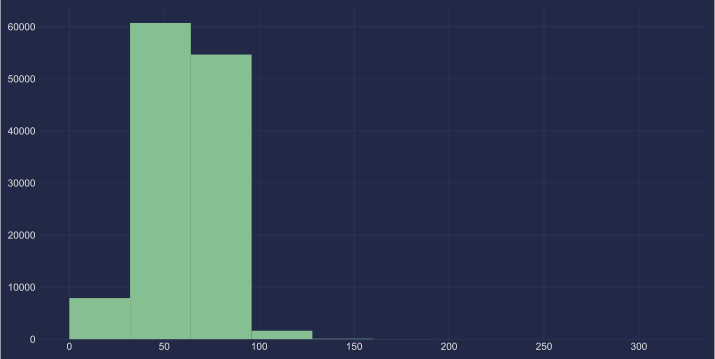

In [69]:
'''
  .hist() -- Creates a histogram chart with a dataframe's Series 
  
  Histograms place a metric in bins -- dates in this case -- to understand the distribution of the data. In this case, the distribution of the data over time
'''
df.headline_length.hist(
  figsize=(12,6),
  color='#86bf91',
)

Looks like there's some variance with some headlines that are over 100 characters long and as much as ~300.

Let's use `.describe()` on this new column as a table of values to review.

In [70]:
df.headline_length.describe()

count    124989.000000
mean         60.023194
std          17.274685
min           0.000000
25%          49.000000
50%          62.000000
75%          71.000000
max         320.000000
Name: headline_length, dtype: float64

##### 2.2.1 Exercise -- Observations about the headlines column

- Headlines longer than 100 characters and up to 300 characters
  - Question: How might this impact our model's output?
  - There is not enough evidence of headlines for these measures that, compared to headlines that are below 100, there is enough evidence. These longer headlines could affect the outcome of our model.
- Headlines that have no characters
  - Question: How might this impact our model's output?
  - I assume this might impact our model's output since it is quite hard to give a correct output from an empty headline. 
- The "Sunday Roundup" headline
  - Question: How might this impact our model's output?
  - This headline is the one that is repeated the most in this dataset and its category is "POLITICS". This might impact our model's output by comparing a similar headline and getting an assumption that the headline analized is of category "POLITICS" as well when it may not be of that category. 

#### 2.2.2 What are the range and distribution of dates?

Since we have a `date` column, and the datatype is in a standardized format, we can quickly plot the date range in a histogram figure.

Let's jot down some observations in our notebook.

**NOTE**: Be sure to respond to the questions and add at least one more potential question, observation, and potential explanation for it

##### 2.2.2.1 *EXERCISE* -- Notes on the distribution of the data based on the `date` column

- Articles' publishing dates range between July 2014 and July 2018
  - Question: How might this impact the model's output?
  - This could create a bias for the model's output since articles that are out of this range are not taken into account.
- Fewer 2018 articles compared to the rest of the dataset.
  - Question: How might this impact the model's output?
  - This could also create a bias since there is no equal data distribution among the different dates. 

<Axes: >

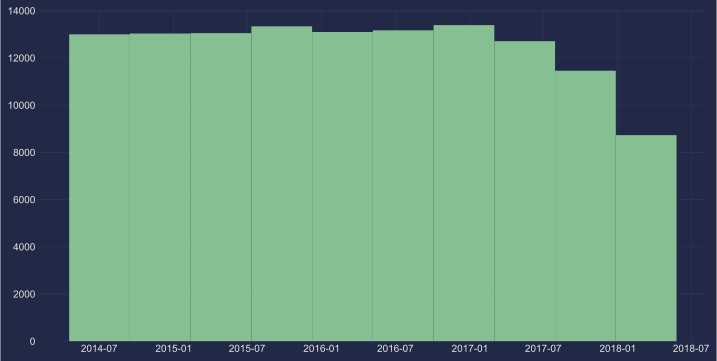

In [71]:
'''
  .hist() -- Creates a histogram chart with a dataframe's Series 
  
  Histograms place a metric in bins -- dates in this case -- to understand the distribution of the data. In this case, the distribution of the data over time
'''

df.date.hist(
  figsize=(12,6),
  color='#86bf91',
)

#### 2.2.3 Describe and examine the `category` column of news genres in the data

Use *dot notation* and a *column name* with `sample()`` to sample values in that column (Series).

**Remember**: The dataframe stays the same because we are not altering `df`.

In [72]:
df.category.sample(5)

40423             CRIME
62023     ENTERTAINMENT
97837             TASTE
107369           IMPACT
35212     THE WORLDPOST
Name: category, dtype: object

Now, let's read and understand the news genre categories (politics, entertainment, etc.) in the dataset, as well as their distribution.

##### 2.2.3.1 Examine the `category` counts and values

We can use the `len()` and `set()` functions in Python to isolate the unique number of values in a column. 

`len()` by itself would provide a length of *all values combined*, even if the value is repeated. By using `set()` first on the column, we can tell Python to reduce the column to unique set of values. Then, it will count that unique set with `len()`.

In [73]:
len(
  set(df['category'].values)
)

31

In [74]:
set(
  df['category'].values
)

{'ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'EDUCATION',
 'ENTERTAINMENT',
 'FIFTY',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'TRAVEL',
 'WEIRD NEWS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST'}

##### 2.2.3.2 `category` by count

Let's review the distribution of categories, since this could impact the model.

In the code below, we tell Python to:

1. Select the `category` column,
2. Count the values of each value in the column with `value_counts()`,
3. Plot the results with `plot` and provide the value `bar` for its parameter `kind`

##### 2.2.3.3 *EXERCISE* -- Notes on the distribution of the data based on the `category` column

- The "WOMEN" category
  - Question: How might this impact our model's output?
  - There exists a "WOMEN" category but I noticed that there is no "MEN" category which might create some bias in our model's output.
- Overlapping categories
  - Question: How might this impact our model's output?
  - The result of our model could be categorized into several categories since there are overlapping categories. 
- The "GOOD NEWS" and "WEIRD NEWS" categories
  - Question: How might this impact our model's output?
  - These categories are very subjectives. Deciding wether news are "good" or "weird" depends on how people define good and weird news. This might affect our model's output since data are categorized by opinions. 

<Axes: xlabel='category'>

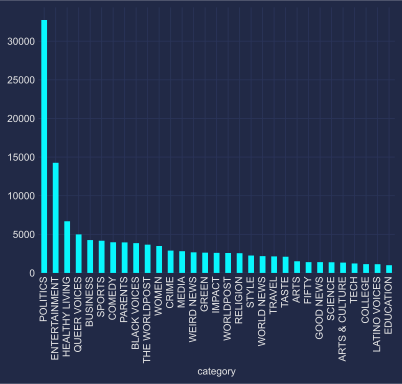

In [75]:
df['category'].value_counts().plot(kind='bar')

#### 2.2.4 Describe and examine the `short_description` column

In [76]:
df.short_description.describe()

count     124989
unique    103905
top             
freq       19590
Name: short_description, dtype: object

In [77]:
df['sd_length'] = df.short_description.apply(len)
df[['short_description','sd_length']].sample(5)

,short_description,sd_length
76351,Creep Lit 101.,14
67458,And the reasons are absurd.,27
117742,"Forgetting can be a beautiful thing, but somet...",137
65234,"Clearly, Trump knows a little something about ...",68
99688,"No. 1 on the list: Big Sur's Post Ranch Inn, w...",388


In [78]:
df.sd_length.describe()

count    124989.000000
mean         92.415373
std          84.832972
min           0.000000
25%          33.000000
50%          76.000000
75%         123.000000
max        1472.000000
Name: sd_length, dtype: float64

<Axes: >

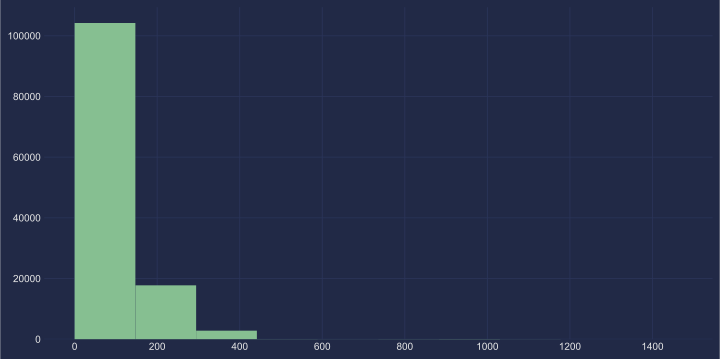

In [79]:
df.sd_length.hist(
  figsize=(12,6),
  color='#86bf91',
)

##### 2.2.4.1 *EXERCISE* -- Notes on the `sd_length` column

- Range of the short description's length is very broad
  - Question: How might this impact our model's output?
  - Having a wider range of datasets might produce a "better" output since datasets covers more with larger range. 
- More articles have short descriptions' lengths betweeen 0 and 150 approx. 
  - Question: How might this impact our model's output?
  - This can create some bias for articles which contain a short description that exceeds the length of 150 characters.
- Short desciptions with no characters
  - Question: How might this impact our model's output?
  - Articles that do not have short descriptions may imply that the article is empty, which affects the result of the model since these empty articles would be taken into account and should not be counted.

## 3. Process the Data for Classification

Some of the fields will be useful to use for the classification task.

1. `headline`: Since we're writing a model to classify headlines, this column is integral to our goal.
2. `short_description`: This column includes a short descrtiption of the story, which will provide potentially helpful contextual information to make a better model for our genre classifier. We'll see!
3. `tokenized_url`: This column includes information too! Different parts of URLs often capture how people have organized and classified information. So, the URL may also provide potentially helpful contextual information to make a better model. Again, we'll see!

The code below creates 3 new columns for that task.

There's a lot to unpack below, but it basically

1. normalizes the URL for each article via the `tokenize_url()` function, which strips the URL down to the portion where the URL conveys article-specific information. Then, 
2. it creates 3 new columns that are combined with the available data.

In [80]:
def tokenize_url(url:str):
    url=url.replace("https://www.huffingtonpost.com/entry/","")
    url=re.sub("(\W|_)+"," ",url)
    return url

df['tokenized_url']=df['link'].apply(lambda x:tokenize_url(x))

#just the description
df['text_desc'] = df['short_description']

#description + headline
df['text_desc_headline'] = df['short_description'] + ' '+ df['headline']

#description + headline + tokenized url
df['text_desc_headline_url'] = df['short_description'] + ' '+ df['headline']+" " + df['tokenized_url']

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124989 entries, 0 to 124988
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   short_description       124989 non-null  object        
 1   headline                124989 non-null  object        
 2   date                    124989 non-null  datetime64[ns]
 3   link                    124989 non-null  object        
 4   authors                 124989 non-null  object        
 5   category                124989 non-null  object        
 6   headline_length         124989 non-null  int64         
 7   sd_length               124989 non-null  int64         
 8   tokenized_url           124989 non-null  object        
 9   text_desc               124989 non-null  object        
 10  text_desc_headline      124989 non-null  object        
 11  text_desc_headline_url  124989 non-null  object        
dtypes: datetime64[ns](1), int64(2)

Let's sample the new row with the URL info to see what it includes.

##### EXERCISE -- Notes on the on the `text_desc_headline_url` column

- It is difficult to differentiate between the description, the title and the tokenized URL.
  - Question: How might this impact our model's output?
  - This column combine the description, headline, and tokenized url into a single value. This might affect our model's ouput since there is no a good separation between these values which makes the value difficult to read and analyze.
- There are some tokenized urls that ends with "html"
  - Question: How might this impact our model's output?
  - There could be some bias in our model output since tokenized URLs are not normalized. Some contain "html" and some do not. This part ("html) does not help the output of our model.

In [81]:
df['text_desc_headline_url'].sample(5).values.tolist()

[' Hemingway, Tourism, and the Contradictions of Revolutionary Cuba he aint my papa hemingway b 5761948 html',
 'He threatened to kill DACA and wants to send the military to the border. All The Ways Trump Amped Up His Immigration Crackdown This Week trump immigration crackdown us 5ac486f3e4b063ce2e5730d4',
 ' Sweden Election Results Offer Uncertain Future For Austerity sweden election results n 5819612 html',
 " Jessica Alba Doesn't Look Like This Anymore jessica alba bob n 6872740 html",
 'Pray for Kev, everybody. Watch Kevin Hart Totally Lose It When He Sees A Giant Python kevin hart python us 56ba4184e4b08ffac122eb85']

## 4. Train a Logistic Regression Model

### 4.1 What's a Logistic Regression Model?

Logistic regression returns a probability that something may or may not happen or "be". We can use this probability as a single value to assess the likelihood of the event/being, such as "This X headline is of Y news genre".

So, let's say our LR model returns a value of 0.990 for a particular headline's news genre as being "POLITICS". This probability score is very likely to accurately predict that this headline is indeed an article about POLITICS. Conversely, another headline with a prediction score of 0.005 on that same logistic regression model is very likely not about POLITICS. Yet, what about a headline with a prediction score of 0.6? 

In this lesson, our LR model uses those probability estimates as a binary category. To do so, we must decide what's called a "classification threshold" or "decision threshold". Any value above that threshold indicates a headline is about POLITICS, and any value below the threshold indicates that the headline is not POLITICS, but some other news genre.

The default decision threshold in the scikit-learn code library that we will use is 0.5. But, this library also enables us to "tune" the LR model based on our problem-dependency / context, as well as take the best/top probability score to predict the news genre of the input headline.

### 4.2 How to Train a Drago... Erm ... a LR Model!

#### 4.2.1 *From Words to Numbers!* - Transform a corpus of words into matrix of integers with `CountVectorizer()`

**Before you review the many functions defined in section 4.2 below**, functions that will automate the modeling process, I want you to understand a very important first step: how we get from word label data to numbers for the model. After all, this is "Writing & Digital Media" **:-)**

So, first things first, we're working with text, so strings and characters. But, a logistic regression model requires numbers. So, we need to extract the features of our corpus and transform them into a data type that can be quantified.

`CountVectorizer()` to the rescue!

To better understand how scikit-learn's built-in functions transform the textual data for us, I provide us with a tiny tiny case of a list of sentences, which transforms our textural data into a **sparse matrix** of values that indicate the frequency of times the word (feature/token) is present in a unit of content (document). 

In this tiny case below, our documents are pretty short strings in a list. Those could be much much bigger, and really it should be for this type of modeling. But, for example purposes, let's see how the matrix logs how many instances a word shows up in each document. 

Each row is the document, (i.e., sentence, in this case), while each column is the feature (word/token). So the values at the intersection of the row and column in the matrix report the raw frequency count (integer).

In [82]:
# Tiny weeny bitty small corpus :-)
# 3 documents (strings) in a list
list_test_text_1 = [
  'Hello my name is chris we are here to do python python python python', 
  'chris this is my python notebook you know python',
  'The python notebook is a chore chris no chris really it is a chore chore chore'
]

# Instantiate an sklearn CountVectorizer (CV) objects
test_cv_object_binary = CountVectorizer(binary=True) #binary values
test_cv_object_counts = CountVectorizer(binary=False) #regular frequency counts
# Instantiate an sklearn TfidfVectorizer objects
test_tfidf_vectorizer_normed = TfidfVectorizer() # normed tfidf scores
test_tfidf_vectorizer = TfidfVectorizer(norm=None, smooth_idf=False) #not normed tfidf scores

# Use the vectorizers' fit_transform() function to conduct the transformation of words into particular quantified values
test_count_matrix_binary = test_cv_object_binary.fit_transform(list_test_text_1)
test_count_matrix_counts = test_cv_object_counts.fit_transform(list_test_text_1)
test_tfidf_matrix_normed = test_tfidf_vectorizer_normed.fit_transform(list_test_text_1)
test_tfidf_matrix = test_tfidf_vectorizer.fit_transform(list_test_text_1)

In [83]:
# Note the specialized data type for sklearn
print(
  'Binary Data Type:',type(test_count_matrix_binary),
  '\nCounts Data Type::',type(test_count_matrix_counts),
  '\nTFIDF Data Type:',type(test_tfidf_matrix),
)

Binary Data Type: <class 'scipy.sparse._csr.csr_matrix'> 
Counts Data Type:: <class 'scipy.sparse._csr.csr_matrix'> 
TFIDF Data Type: <class 'scipy.sparse._csr.csr_matrix'>


If I try to print out the sklearn cv matrix, I'll get some basic data structural info.

In [84]:
print(test_count_matrix_binary.get_shape())

(3, 20)


The matrix has 3 rows (documents/sentences) and 20 columns (unique words/tokens) with values that are dependent on the type of summary: binary, counts, or tfidf.

Let's check out the now transformed/quantified data by converting the returned sparse matrices as a more recognizable data type: a pandas dataframe.

In [85]:
def convert_sparse_matrix_to_df(matrix, vectorized_object):
  # Convert the matrix into a more basic Python array
  count_array = matrix.toarray()

  # Use that array as the data in the DF, then nicely use CV or TFIDF vector object's `get_feature_names_out()` method to provide the column names
  sparse_matrix_as_df = pd.DataFrame(
    data=count_array,
    columns=vectorized_object.get_feature_names_out()
  )

  return sparse_matrix_as_df

In [86]:
# Binary
convert_sparse_matrix_to_df(test_count_matrix_binary, test_cv_object_binary)

,are,chore,chris,do,hello,here,is,it,know,my,name,no,notebook,python,really,the,this,to,we,you
0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,0,0,0,1,1,0
1,0,0,1,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,0,1
2,0,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,0,0,0,0


In [87]:
# Counts
convert_sparse_matrix_to_df(test_count_matrix_counts, test_cv_object_counts)

,are,chore,chris,do,hello,here,is,it,know,my,name,no,notebook,python,really,the,this,to,we,you
0,1,0,1,1,1,1,1,0,0,1,1,0,0,4,0,0,0,1,1,0
1,0,0,1,0,0,0,1,0,1,1,0,0,1,2,0,0,1,0,0,1
2,0,4,2,0,0,0,2,1,0,0,0,1,1,1,1,1,0,0,0,0


In [88]:
# Not Normed TF-IDF
convert_sparse_matrix_to_df(test_tfidf_matrix, test_tfidf_vectorizer)

,are,chore,chris,do,hello,here,is,it,know,my,name,no,notebook,python,really,the,this,to,we,you
0,2.098612,0.000000,1.0,2.098612,2.098612,2.098612,1.0,0.000000,0.000000,1.405465,2.098612,0.000000,0.000000,4.0,0.000000,0.000000,0.000000,2.098612,2.098612,0.000000
1,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.0,0.000000,2.098612,1.405465,0.000000,0.000000,1.405465,2.0,0.000000,0.000000,2.098612,0.000000,0.000000,2.098612
2,0.000000,8.394449,2.0,0.000000,0.000000,0.000000,2.0,2.098612,0.000000,0.000000,0.000000,2.098612,1.405465,1.0,2.098612,2.098612,0.000000,0.000000,0.000000,0.000000


In [89]:
# Normed TF-IDF
convert_sparse_matrix_to_df(test_tfidf_matrix_normed, test_tfidf_vectorizer_normed)

,are,chore,chris,do,hello,here,is,it,know,my,name,no,notebook,python,really,the,this,to,we,you
0,0.268634,0.000000,0.158660,0.268634,0.268634,0.268634,0.158660,0.000000,0.000000,0.204303,0.268634,0.000000,0.000000,0.634638,0.000000,0.000000,0.000000,0.268634,0.268634,0.000000
1,0.000000,0.000000,0.236251,0.000000,0.000000,0.000000,0.236251,0.000000,0.400008,0.304216,0.000000,0.000000,0.304216,0.472502,0.000000,0.000000,0.400008,0.000000,0.000000,0.400008
2,0.000000,0.821339,0.242548,0.000000,0.000000,0.000000,0.242548,0.205335,0.000000,0.000000,0.000000,0.205335,0.156162,0.121274,0.205335,0.205335,0.000000,0.000000,0.000000,0.000000


**What do we notice?**

All dataframe/matrices include:

- 3 rows == number of documents
- 20 columns == Set number of terms/tokens
- **Binary** values are either 0 or 1 
- **Counts** values are the *frequency* of times a word shows up in a document
- **TFIDF** values are a type of *weighted average* score per word in a document

##### So what is TFIDF, again?

TF-IDF measures how important a *term* is within a *document* relative to a *collection of documents/corpus*. It is comprised of 2 values: _Term Frequency/commonality_ &amp; _Inverse Document Frequency/rarity_. In our test simple case, we have 3 documents (3 lists of strings), wherein the total number of words/tokens across all docs is 36.

A term's TF-IDF score is high when it is frequently used in a document **and rarely** in other documents in the collection. Conversely, a term's TF-IDF score is lowered when it is just as frequently a document **and frequently** in other documents in the collection. Consequently, a term's commonality within a document (TF) is balanced by the term's rarity across all documents (IDF), which provides one useful score to measure the importance of a term for a document in the corpus.

**Term Frequency**

A term's *commonality* -- Number of times the term appears in a document compared to the total number of words in the document. -- TF = Frequency of term in a document / Total number of tokens (39)

<p><mjx-container class="MathJax CtxtMenu_Attached_0" jax="CHTML" display="true" style="position: relative;" tabindex="0" ctxtmenu_counter="12"><mjx-math display="true" style="margin-left: 0px; margin-right: 0px;" class="MJX-TEX" aria-hidden="true"><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D447 TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D439 TEX-I"></mjx-c></mjx-mi><mjx-mo class="mjx-n" space="4"><mjx-c class="mjx-c3D"></mjx-c></mjx-mo><mjx-mfrac space="4"><mjx-frac type="d"><mjx-num><mjx-nstrut type="d"></mjx-nstrut><mjx-mtext class="mjx-n"><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c62"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c66"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c69"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c73"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c68"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c61"></mjx-c><mjx-c class="mjx-c70"></mjx-c><mjx-c class="mjx-c70"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c61"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c73"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c69"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c68"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c64"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c63"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c74"></mjx-c></mjx-mtext></mjx-num><mjx-dbox><mjx-dtable><mjx-line type="d"></mjx-line><mjx-row><mjx-den><mjx-dstrut type="d"></mjx-dstrut><mjx-mtext class="mjx-n"><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c61"></mjx-c><mjx-c class="mjx-c6C"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c62"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c66"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c73"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c69"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c68"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c64"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c63"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c74"></mjx-c></mjx-mtext></mjx-den></mjx-row></mjx-dtable></mjx-dbox></mjx-frac></mjx-mfrac></mjx-math><mjx-assistive-mml unselectable="on" display="block"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>T</mi><mi>F</mi><mo>=</mo><mfrac><mtext>number of times the term appears in the document</mtext><mtext>total number of terms in the document</mtext></mfrac></math></mjx-assistive-mml></mjx-container></p>

In [90]:
test_total_terms_in_collection = len( (list_test_text_1[0] +' '+ list_test_text_1[1] +' '+ list_test_text_1[2]).split() )
test_total_terms_in_collection

39

In [91]:
# Term Frequency (TF) for 'python' in second document, i.e., string in the list
tf_python_d1 = 4 / test_total_terms_in_collection
tf_chore_d3 = 4 / test_total_terms_in_collection
print(
  'TF \'python\':', tf_python_d1,
  '\nTF \'chore\':', tf_chore_d3,
)

TF 'python': 0.10256410256410256 
TF 'chore': 0.10256410256410256


**Inverse Document Frequency**: A term's *rarity* -- IDF of a term reflects the proportion of documents in the corpus that contain the term. Words unique to a small percentage of documents (e.g., technical jargon terms) receive higher importance values than words common across all documents (e.g., a, the, and).

<p><mjx-container class="MathJax CtxtMenu_Attached_0" jax="CHTML" display="true" style="position: relative;" tabindex="0" ctxtmenu_counter="13"><mjx-math display="true" style="margin-left: 0px; margin-right: 0px;" class="MJX-TEX" aria-hidden="true"><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D43C TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D437 TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D439 TEX-I"></mjx-c></mjx-mi><mjx-mo class="mjx-n" space="4"><mjx-c class="mjx-c3D"></mjx-c></mjx-mo><mjx-mi class="mjx-i" space="4"><mjx-c class="mjx-c1D459 TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D45C TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D454 TEX-I"></mjx-c></mjx-mi><mjx-mo class="mjx-n"><mjx-c class="mjx-c28"></mjx-c></mjx-mo><mjx-mfrac><mjx-frac type="d"><mjx-num><mjx-nstrut type="d"></mjx-nstrut><mjx-mtext class="mjx-n"><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c62"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c66"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c68"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c64"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c63"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c73"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c69"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c68"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c63"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c70"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c73"></mjx-c></mjx-mtext></mjx-num><mjx-dbox><mjx-dtable><mjx-line type="d"></mjx-line><mjx-row><mjx-den><mjx-dstrut type="d"></mjx-dstrut><mjx-mtext class="mjx-n"><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c62"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c66"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c64"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c63"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c6D"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c73"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c69"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c68"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c63"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c70"></mjx-c><mjx-c class="mjx-c75"></mjx-c><mjx-c class="mjx-c73"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c63"></mjx-c><mjx-c class="mjx-c6F"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c61"></mjx-c><mjx-c class="mjx-c69"></mjx-c><mjx-c class="mjx-c6E"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c68"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c20"></mjx-c><mjx-c class="mjx-c74"></mjx-c><mjx-c class="mjx-c65"></mjx-c><mjx-c class="mjx-c72"></mjx-c><mjx-c class="mjx-c6D"></mjx-c></mjx-mtext></mjx-den></mjx-row></mjx-dtable></mjx-dbox></mjx-frac></mjx-mfrac><mjx-mo class="mjx-n"><mjx-c class="mjx-c29"></mjx-c></mjx-mo></mjx-math><mjx-assistive-mml unselectable="on" display="block"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>I</mi><mi>D</mi><mi>F</mi><mo>=</mo><mi>l</mi><mi>o</mi><mi>g</mi><mo stretchy="false">(</mo><mfrac><mtext>number of the documents in the corpus</mtext><mtext>number of documents in the corpus contain the term</mtext></mfrac><mo stretchy="false">)</mo></math></mjx-assistive-mml></mjx-container></p>

In [92]:
idf_d1_python = np.log10(3 / 3)
idf_d3_chore = np.log10(3 / 1)
print(
  'IDF \'python\':', idf_d1_python,
  '\nIDF \'chore\':', idf_d3_chore,
)

IDF 'python': 0.0 
IDF 'chore': 0.47712125471966244


In [93]:

print(
  'TF-IDF of \'python\' in doc 1 of the collection/corpus:', (tf_python_d1 * idf_d1_python),
  '\nTF-IDF of \'chore\' in doc 3 of the collection/corpus:', (tf_chore_d3 * idf_d3_chore),
)

TF-IDF of 'python' in doc 1 of the collection/corpus: 0.0 
TF-IDF of 'chore' in doc 3 of the collection/corpus: 0.04893551330458076


##### Summarize `CountVectorizer()` &amp; `TfidfVectorizer()`

In the modeling functions below, the `extract_features()` function uses `CountVectorizer()` and `TfidfVectorizer()` to, well, extract these features from the much larger corpus. 

They both nicely automate the process for us: writing and calculating at amazing speed and scale. 

**Can you imagine transforming the data manually?!** I don't think we want to subject ourselves to even such a thought.

### 4.3 Modeling functions

The functions below help us create a systematic and reproducable workflow to train the data.

Be sure to check out my videos that walk through an overview of what they do.

In [94]:
def _reciprocal_rank(true_genre_labels: list, machine_predicted_genre_labels: list):
    '''
    ## Purpose
    Compute the reciprocal rank at cutoff k

    ## Parameters
        - `true_genre_labels` (List): List of actual news genre labels
        - `machine_predicted_genre_labels` (List): List of news genre labels predicted by the LR algorithm
    
    ## Return Values
        - `recip_rank` (Float): Reciprocal rank
    '''
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_predicted_genre_labels) if r in true_genre_labels]

    recip_rank = 0
    if len(tp_pos_list) > 0:
        # for reciprocal rank we must find the position of the first **correctly labeled** item
        first_pos_list = tp_pos_list[0]
        
        # recip_rank = 1/rank
        recip_rank = 1 / float(first_pos_list)

    return recip_rank

def compute_mrr_at_k(eval_news_category_items:list):
    '''
    ## Purpose
    `compute_mrr_at_k()`: Computes the MRR (average RR) at cutoff k. In sum, it takes the mean average of all of the reciprocal rank scores among the actual vs. predicted labels. Review this ["Mean reciprocal rank" wikipedia article](https://en.wikipedia.org/wiki/Mean_reciprocal_rank) for a simple explainer.
    ## Parameters
    - `eval_news_category_items` (List): List that contains 2 values
        1. String - Actual news genre category
        2. List of strings - Predicted news genre category in order by estimated probability to be returned by the model.
            - The example below shows how 
                - `'HEALTHY LIVING'` was the actual label, but it was third in 'reciprocal rank' with a value of 1/3
                - `'WORLDPOST'` was the actual label, and it was first in 'reciprocal rank' with a value of 1
                
                [
                    [
                        ['HEALTHY LIVING'], ['POLITICS', 'ENTERTAINMENT', 'HEALTHY LIVING']
                    ], 
                    [
                        ['WORLDPOST'], ['WORLDPOST', 'MEDIA', 'POLITICS']
                    ], 
                    ...
                ]

    ## Return Values
        - `mean_reciprocal_rank_score` (Float): Mean average reciprocal rank score among the predicted news category in the model
    '''
    rr_total = 0
    
    for item in eval_news_category_items:
        actual_label = item[0]
        pred_label_list = item[1]

        # Find the reciprocal rank (RR) for this row
        rr_at_k = _reciprocal_rank(actual_label, pred_label_list)

        # Add the row's RR to the accruing scores for the entire corpus
        rr_total = rr_total + rr_at_k

        # Update the Mean Reciprocal Rank (MRR) score with new row value
        mean_reciprocal_rank_score = rr_total / 1/float(len(eval_news_category_items))

    return mean_reciprocal_rank_score

def collect_preds(Y_test, Y_preds):
    '''
    ## Purpose
    Collect all predictions (predicted news genre labels) and ground truth (i.e., actual news genre label)
    '''
    pred_gold_list = [ [ [Y_test[index]], pred ] for index, pred in enumerate(Y_preds) ]
    return pred_gold_list
             
def compute_accuracy(eval_news_category_items:list):
    '''
    ## Purpose
    `compute_accuracy()`: Compute the overall accuracy score of the model across the training corpus

    ## Parameters
        - `eval_news_category_items` (List): List that contains 2 values
            1. String - Actual news genre category
            2. List of strings - Predicted news genre category

            Example: [
                [
                    ['HEALTHY LIVING'], ['POLITICS', 'ENTERTAINMENT', 'HEALTHY LIVING']
                ], 
                [
                    ['WORLDPOST'], ['WORLDPOST', 'MEDIA', 'POLITICS']
                ], 
                ...
            ]
    ## Return Values
        - `news_cat_prediction_accuracy` (Float): Percentage of accurately predicted news category in the model
    '''
    correct_news_cat = 0
    
    for news_genre_cat in eval_news_category_items:
        true_pred = news_genre_cat[0]
        machine_pred = set(news_genre_cat[1])
        
        for news_cat in true_pred:
            if news_cat in machine_pred:
                correct_news_cat += 1
                break
    
    news_cat_prediction_accuracy = correct_news_cat / float(len(eval_news_category_items))
    return news_cat_prediction_accuracy



In [95]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df, field, training_data, testing_data, type='binary'):
    '''
    ## Purpose
    `extract_features()`: Extract features using different method types: binary, counts, or TF-IDF

    ### If BINARY Features
    Creates a new `CountVectorizer()` method object, which converts a collection of text documents to a matrix of binary token counts per document. In other words, 
    - `1` == the feature is represented in the document
    - `0` == the feature is not represented in the doc
    
    Logistic regression involves vectorizing weighted averages of these tokens.

    ### If COUNT Features
    Creates a new `CountVectorizer()` method object, which converts a collection of text documents to a matrix of `n` token counts per document.  In other words, 
    - `5` == the feature is represented 5 times in the document
    - `25` == the feature is represented 25 times in the document
    - `0` == the feature is not represented in the doc
    
    Logistic regression involves vectorizing weighted averages of these tokens.

    ### If TF-IDF Features
    Creates a new `CountVectorizer()` method object, which converts a collection of text documents to a matrix of `n` token counts per document.  In other words, 
    - `5` == the feature is represented 5 times in the document
    - `25` == the feature is represented 25 times in the document
    - `0` == the feature is not represented in the doc
    
    Logistic regression involves vectorizing weighted averages of these tokens.
    '''
    
    logging.info("Extracting features and creating vocabulary...")

    '''
        BINARY and COUNTS PROCESSES WILL DO THE FOLLOWING:

        sklearn's CountVectorizer() will convert text to numerical data.
    '''
    
    if 'binary' in type:
        
        # BINARY FEATURE REPRESENTATION
        # Creates a new CountVectorizer() method object, which can help us use built-in functions that convert a collection of text documents to a matrix of token counts. **REMEMBER** that logistic regression involves vectorizing weighted averages of these tokens.
        # NOTE: `max_df` == "Maximum Document Frequency. It enables us to programmatically ignore frequently occuring words, e.g., articles like 'a' or 'the'. `max_df` reviews how many documents contain the word, and if it exceeds the max_df threshold then it is eliminated from the sparse matrix. Below we set the threshold to 95%.
        cv = CountVectorizer(binary=True, max_df=0.95)
        # CountVectorizer()'s fit_transform() uses the training_data to learn the vocabulary dictionary and return document-term matrix.
        cv.fit_transform(training_data[field].values)
        # CountVectorizer()'s transform() 
        train_feature_set = cv.transform(training_data[field].values)
        test_feature_set = cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif 'counts' in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv = CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set = cv.transform(training_data[field].values)
        test_feature_set = cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    elif 'tfidf':    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model, X_test, k, threshold=False):
    '''
    ## Purpose
    `get_top_k_predictions()`: Uses the input trained LogisticRegression model to return the news genre class/category with the top estimated probability score.
    ## Parameters
    - `model` (LogisticRegression()): Trained model scikit-learn object
    - `X_test` (pandas DataFrame): Sampled test data set returned by `training_test_split()` in the `training_model()` function
    - `k` (Integer): Number of top categories (news genres) to return based on the estimated probability to predict the news genre
    ## Return Value(s)
    - `preds` (List of list): A list within a list of the top k retruned news categories. For example:
        - `preds` is `[['SCIENCE', 'HEALTHY LIVING', 'GREEN']]` for an article with the headline of `"Exercise in space keeps astronauts from fainting when they return to Earth, study says"` and `k=3`
    '''
    if threshold == False:
        # get probabilities instead of predicted labels, since we want to collect top 3
        probs = model.predict_proba(X_test)

        # GET TOP K PREDICTIONS BY PROB - note these are just index
        best_n = np.argsort(probs, axis=1)[:,-k:]
        
        # GET CATEGORY OF PREDICTIONS
        preds = [[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
        
        preds = [ item[::-1] for item in preds]
    
        return preds
    else:
        # get probabilities instead of predicted labels, since we want to collect top 3
        probs = (model.predict_proba(X_test)[:,1] >= thresh_val)

        # GET TOP K PREDICTIONS BY PROB - note these are just index
        best_n = np.argsort(probs, axis=1)[:,-k:]
        
        # GET CATEGORY OF PREDICTIONS
        preds = [[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
        
        preds = [ item[::-1] for item in preds]
    
        return preds
   
def train_model(df, field="text_desc", feature_rep="binary", top_k=3):
    '''
    ## Purpose
    train_model() is the main controller function that conducts the following modeling procedure: 
        
    1. Create X data (List) by splitting the data to create two sampled sets: 1) for training, and 2) for testing.
    2. Create Y data (List) by assigning the actual (ground truth) labels
    3. Extract the features for the model to use, based on the chosen feature representation: binary vs. TF-IDF
    4. Fit, i.e., train, the logistic regression classifier model with scikit-learn's `LogisticRegression()` object
    5. Retrieve the evaluation items, e.g., the actual labels (ground truths) and predicted labels (list of top `k` number of estimated probable predicted categories)
    6. Use the evaluation iitems to compute the overall accuracy score and mean reciprocal rank score of the model

    ## Parameters
    - `df` (pandas DataFrame): the complete data set / corpus
    - `field` (String): the column name of the feature used to train the model
    - `feature_rep` (String): Type of LR analysis set as either "binary" or "count" or "tfidf"
    '''
    
    logging.info("Starting model training...")
    
    # 1. GET A TRAIN TEST SPLIT (set seed for consistent results)
    # train_test_split() from sklearn "splits arrays or matrices into random train and test subsets."
    # returns 2 new dataframes: one for training, another for testing the trained model
    y = df['category']
    x_training_data,x_testing_data = train_test_split(
        df,
        random_state=2000 #Controls the shuffling applied to the data before applying the split
    )

    # 2. GET LABELS FROM SPLIT DATA
    # Get the category values from each split data returned by #1
    Y_train = x_training_data['category'].values
    Y_test = x_testing_data['category'].values
     
    # 3. GET FEATURES
    X_train,X_test,feature_transformer = extract_features(
        df,
        field,
        x_training_data,
        x_testing_data,
        type=feature_rep
    )

    # INITIALIZE THE LOGISTIC REGRESSION CLASSIFIER OBJECT
    logging.info("Training a Logistic Regression Model. This may take a few minutes. ...")
    scikit_log_reg = LogisticRegression(
        verbose=0, #if you want the LR method to print out all the details, change this 0 to 1
        solver='liblinear',
        random_state=0,
        C=5,
        penalty='l2',
        max_iter=1000
    )
    # Create the model by providing the LR object the 
    model = scikit_log_reg.fit(X_train, Y_train)

    # GET TOP K PREDICTIONS
    preds = get_top_k_predictions(model, X_test, top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items = collect_preds(Y_test, preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    simple_mean_avg_correct_prediction_accuracy = compute_accuracy(eval_items)
    mean_recip_rank_at_k = compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")

    # Return the herein computed model and other values for potential use and exploration
    return model,feature_transformer,simple_mean_avg_correct_prediction_accuracy,mean_recip_rank_at_k,X_train,X_test,Y_test,Y_train,preds,eval_items


### 4.4 LR Model 1 - Binary or Count features with `text_desc` only

Train the model based on the short description data.

**FYI**. Your functions can return multiple variables, if you'd like. 

If you review the `train_model()` function, it returns multiple variables in a specific order. Those mirror the variables and the comma-separated variables and their desired types below.

#### 4.4.1 Enact the Training

In [96]:
'''
  Parameters to configure for our train_model() function
'''

# Use the short description only to train a model
training_field = 'text_desc'
# Specify if this model should use a binary approach to the features (0 or 1) or the actual counts created by CountVectorizer()
# Let's use counts
feature_rep = 'counts'
# Tell the model function to return the top 3 'best fits' among the distributed probabilities
top_k = 3

# Train that supervised ML logistic regression model!
model_td_only,transformer_td_only,accuracy_td_only,mrr_at_k_td_only,X_train,X_test,Y_test,Y_train,preds,eval_items = train_model(
  df, # full corpus
  field=training_field,
  feature_rep=feature_rep,
  top_k=top_k
)

2023-11-16 23:25:20,507 : INFO : Starting model training...
2023-11-16 23:25:20,534 : INFO : Extracting features and creating vocabulary...
2023-11-16 23:25:21,752 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-11-16 23:27:50,608 : INFO : Starting evaluation...
2023-11-16 23:27:50,648 : INFO : Done training and evaluation.


#### Model Assessment Roadmap

In the following subsections, you will examine the LR model that you just trained by:

1. Print out the overall accuracy scores for the model
2. Compare the predictive power of the model across the news genre categories, i.e., *classes*
3. Visualize the predictive power per class/category with a "confusion matrix" heatmap
4. Dig deeper into the categories by comparing some categories' performance against the EDA work on the data set used to train the model

#### 4.4.2 Test the accuracy/performance of the model

##### 4.4.2.1 See the accuracy and Mean Reciprocal Rank Scores

We already computed the overall accuracy and MRR scores, when we trained the model, so let's output them.

If you need to refresh yourself on these scores, check out the functions' documentation in the 4.3 section.

In [97]:
print(f"Overall Mean Average Model Accuracy = {accuracy_td_only}\nMean Reciprocal Rank = {mrr_at_k_td_only}")

Overall Mean Average Model Accuracy = 0.5955581157194061
Mean Reciprocal Rank = 0.47845728793311004


##### 4.4.2.2 Compare Actual Labels (ground truths) with Predicted Labels (with the k threshold)

Before we test our model with headline inputs, we can test its performance with scikit-learn's `predict_proba()` associated function with the output model.

This function returns the estmated probability of each categorical label (news genre) in the test sample. With this returned data set, we can visualize the results to see what categories might be mislabeled more often than others and, of course, which categories are performing well.

Here is a description of parameter and return data:
- `X_test`: sample of the original data to test the trained model
- `Y_probability_td_only`: List of the predicted news genre category outputs (String)
- `Y_probability_a_td_only`: List of lists of the predicted news genre category based on the estimated probability score
  - First list == 1 row from X_test data set
    - Lists within that list == Each list contains estimated probability scores (Float) per (31) news genre categories

In [98]:
# Predict the classes on the test data
Y_predictions_td_only = model_td_only.predict(X_test)
# Predict the classes on the test data, and return the probabilities for each class
Y_probability_a_td_only = model_td_only.predict_proba(X_test)

#### 4.4.3 Visualize Actual vs. Prediction with a Confusion Matrix

A confusion matrix helps you organize a direct comparison across all of your possible categories. Essentially, it asks: 

1. How many times did X (actual) equal the predicted (Y)?
2. How many times did X (actual) not equal the predicted (Y)?

Another way to phrase the questions is to think of it in action. So, with this data set, there are 31 possible categories (news genres), which means we have 31 categories to test against each other—**that's 961 categories** (31 * 31 = 961)!

A confusion matrix maps what are called the True Positive, False Positive, False Negative, and True Negative prediction outcomes. In the table below, I provide a high-level description of what each of these values represent in the scheme of our LR model on predicting news genres.

<div style="max-width:700px;">
  <table border="1">
  <tbody><tr>
    <td style="background:lightgreen" width="50%">
      <b>True Positive (TP):</b>
      <ul>
        <li>Reality: Input SCIENCE headline</li>
        <li>LR predicted: "SCIENCE"</li>
        <li>Outcome: LR's prediction is correct/accurate</li>
      </ul>
    </td>
    <td style="background:pink">
      <b>False Positive (FP):</b>
      <ul>
        <li>Reality: Input is <strong>NOT</strong> a SCIENCE headline</li>
        <li>LR predicted: "SCIENCE"</li>
        <li>Outcome: LR's prediction is incorrect/inaccurate</li>
    </ul></td>
  </tr>
  <tr>
    <td style="background:pink">
      <b>False Negative (FN):</b>
      <ul>
        <li>Reality: Input SCIENCE headline</li>
        <li>LR predicted: <strong>NOT</strong> "SCIENCE"</li>
        <li>Outcome: LR's prediction is incorrect/inaccurate</li>
      </ul>
    </td>
    <td style="background:lightgreen">
      <b>True Negative (TN):</b>
      <ul>
        <li>Reality: Input is <strong>NOT</strong> a SCIENCE headline</li>
        <li>LR predicted: <strong>NOT</strong> "SCIENCE"</li>
        <li>Outcome: LR's prediction is correct/accurate</li>
      </ul>
    </td>
  </tr>
</tbody></table></div>
</div>

Ok, so let's visualize the TPs, FPs, FNs, and TNs as a heatmap with annotated values for quick reference.

In [99]:
cm_td_only = confusion_matrix(
  Y_test, #Sorted List of ground truth (correct/actual) target values
  Y_predictions_td_only #Sorted List of estimated targets as returned by a classifier
)

In [100]:
cm_td_only[0]

array([ 39,  18,   6,   7,   3,   7,   0,   0,  46,   1,   0,   0,   6,
         3,   4,   5,   7, 182,   8,   5,   1,   2,   2,   3,   2,   0,
         3,   0,   5,   0,   5])

Let's be sure to **normalize the confusion matrix values**.

The current values in the confusion matrix are simply counts (Integers). But, if we want to visualize the prediction efficacy as a heatmap, we first need to "normalize" the values by converting them to a score relative to all of the other comparisons in the same column. For example, `ARTS` has results across 31 categories

In [101]:
# Normalize matrix by columns
cm_td_only_normed_by_column = normalize(cm_td_only, axis=1, norm='l1')
# Compare the original to the normalized
print(
  'Simple Counts of the ARTS (first) column:\n', cm_td_only[0],'\n\n',
  'Normalized Counts of the ARTS (first) column:\n',cm_td_only_normed_by_column[0],
)

Simple Counts of the ARTS (first) column:
 [ 39  18   6   7   3   7   0   0  46   1   0   0   6   3   4   5   7 182
   8   5   1   2   2   3   2   0   3   0   5   0   5] 

 Normalized Counts of the ARTS (first) column:
 [0.10540541 0.04864865 0.01621622 0.01891892 0.00810811 0.01891892
 0.         0.         0.12432432 0.0027027  0.         0.
 0.01621622 0.00810811 0.01081081 0.01351351 0.01891892 0.49189189
 0.02162162 0.01351351 0.0027027  0.00540541 0.00540541 0.00810811
 0.00540541 0.         0.00810811 0.         0.01351351 0.
 0.01351351]


##### 4.4.3.2 Heatmap of the `text_desc` only normalized confusion matrix

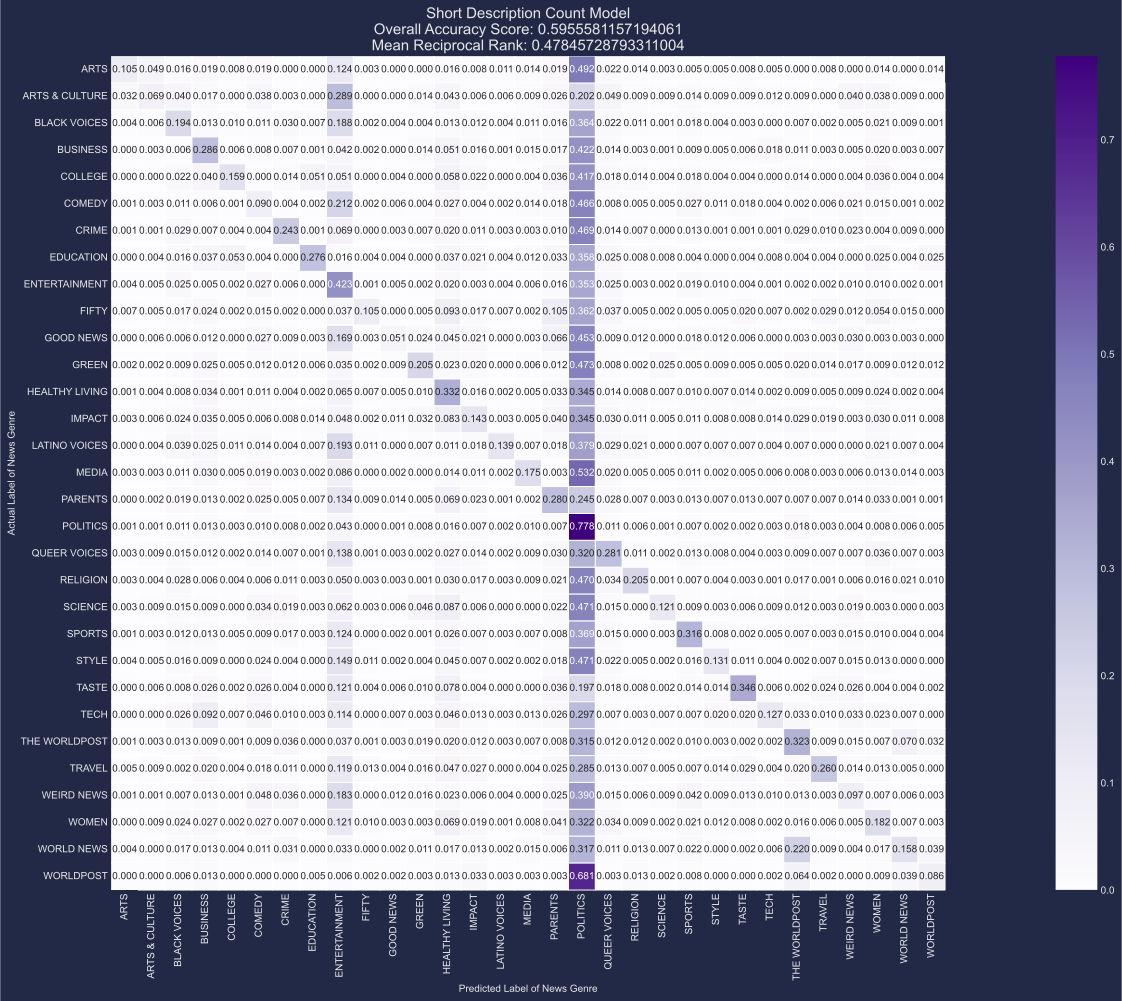

In [102]:
plt.figure(figsize=(31,14))

sns.heatmap(
  cm_td_only_normed_by_column, #normalized confusion matrix
  annot=True, # add normalized counts of co-occurrences between actual vs. predicted
  fmt=".3f", # round to thousandths decimal place
  linewidths=1, # style choice for row/column lines
  square=True, # make the 
  cmap='Purples',
  xticklabels=model_td_only.classes_,
  yticklabels=model_td_only.classes_,
)

# Label the X and Y axes
plt.ylabel('Actual Label of News Genre')
plt.xlabel('Predicted Label of News Genre')

# Let's plug in our overall accuracy measures into the the title
all_sample_title = f"Short Description Count Model\nOverall Accuracy Score: {accuracy_td_only}\nMean Reciprocal Rank: {mrr_at_k_td_only}"
plt.title(
  all_sample_title,
  size=15
)

# Ok, output time!
plt.tight_layout()
mplcyberpunk.add_glow_effects()
plt.show()

#### 4.4.4 Explore and Assess Categories/Classes with True Positive Rates, False Positive Rates, etc.

Based on the above overall accuracy score and heatmap results per category, you can begin to identify news genre categories (or classes) that may be performing well versus categories that are not performing well. You can use the following code below to explore those performance biases per news genre in the corpus/model.

As you work through the code below, take notes as you compare the overall accuracy score of the model with specific optimal threshold scores, and be sure to compare those results against the EDA work that you conducted earlier in the notebook. 

Our LR model has 31 classes (news genres), so it's a "multi-class" LR model. To help us explore the predictive accuracy across each class, we must first use scikit-learn's `LabelBinarizer()` to enable us to compute the True Positive Rates (TPR) and False Positive Rates (FPR) for each class/category.

The 3 variables assigned below will help us process the training and testing data to do so.

##### 4.4.4.1 - Create data set of binary predictions per row across all of our classes

In [103]:
# scikit-learn's LB() will turn the prediction output on the test data into zeroes and ones, where 1 == the predicted class (news genre) and 0 == not predicted class
label_binarizer = LabelBinarizer().fit(Y_test)

# This variable transforms the predictions into the 0s and 1—commonly referred to as either the "one vs all" test or "one hot" test. (I actually don't know the origin of the 'one hot' term.)
y_onehot_test = label_binarizer.transform(Y_test)

# (rows == X inputs, columns == Y possible predicted classes)
y_onehot_test.shape

(31248, 31)

It is always a good practice to print out your data in some manner, so you can better understand and be sure that it's what you want/need.

In [104]:
# Reviews the test data per row and returns a binary
print(
  'Number of Classes/News Genres:',len(y_onehot_test[0]),
  '\nFirst row in test set:',y_onehot_test[0],
  '\nPrediction (1):',Y_test[0]
)

Number of Classes/News Genres: 31 
First row in test set: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
Prediction (1): HEALTHY LIVING


##### 4.4.4.2 - Use that data to visualize the TPs & FPs with an "ROC Curve" & "Area Under the Curve"

An *ROC curve* (Receiver Operating Characteristic curve) is a tool to identify the relationship between the accurate "hit rate" (TP) and accurate "false alarms" (FP). 

This curve plots the False Positive (x) and True Positive (y) rates at their different classification thresholds to help us visualize the performance of the model at different potential thresholds. In effect, this visual can help you isolate the performance of some classes over others in relationship with the original EDA work that you have conducted.

You can also use ROC curve plots to see how when you lower the classification threshold, the model will classify more items as positive and increase both False Positives and True Positives.

The goal is to identify the optimal Area Under the Curve (AUC). It aggregates all of the probable classification values as a normalized value between 0 and 1 for each new input in the data set. 
- 0 == The model is wrong 100% of the time
- 1 == The model is correct 100% of the time

Think of it like the spectrum between 0 and 1 below, where the random positive predictions are positioned to the right of the random negative predictions. So, if the AUC score is `0.714`, then the probability that `p` is positioned to the right of `n` is `71.4%`.

```
Ouput of the LR Model
n = Actual Negative Prediction
p = Actual Positive Prediction
____0
|n
|n
|n
|n
|n
|n
|n
|n
|n
|p
|n
|n
|p
|p
|n
|p
|p
|p
|p
|p
|p
————1
```

Ok, that is a lot of info. Let's see some different visual methods to help us understand ROC curves as a means to plot the relationship between FP rates and TP rates.

##### 4.4.4.3 - Functions to Generate FPR, TPR, ROC, and AUC Data & Visualizations

First, here are some functions to automate the work a little bit. I've provided some basic documentation per function for you to review.

In [105]:
def roc_curve_per_category(list_classes, y_proba, y_one_vs_all):
  '''
  ## Purpose
  `roc_curve_per_category`: Combine all of the ROC () values for each category in one DataFrame

  ## Parameters
  - `list_classes` (List): A list of the classes in the trained model
  - `y_proba` (Numpy array sparse matrix): A list of lists where each sublist contains estimated probability scores of each X input across all possible Y classes/categories
  - `y_one_vs_all` (Numpy array sparse matrix): A list of lists, where each sublist contains binary 0 or 1 values representing the predicted class/category as 1 (Int) and all other classes/categories as 0 (Int)

  ## Return Value(s)
  - `df_fpr_tpr` (pandas DataFrame): Dataframe with the following values per row:
    - `'Class'`: Class from the model for instance
    - `'FPR'`: False Positive Rate for instance
    - `'TPR'`: True Positive Rate for instance
    - `'Threshold_Value'`: Threshold Value for instance
    - `'Threshold_Optimal'`: Optimal threshold value for the class as a whole
    - `'FPR_Optimal'`: Optimal FPR value for the class as a whole
    - `'TPR_Optimal'`: Optimal TPR value for the class as a whole
  '''
  list_dicts_classes_roc = []

  for class_cat in list_classes:
    # get class category (news genre)
    class_id = np.flatnonzero(label_binarizer.classes_ == class_cat)[0]
    y_proba[:, class_id]

    fpr, tpr, thresholds = roc_curve(y_one_vs_all[:, class_id], y_proba[:, class_id])
    
    # Calculate the Geometric-Mean
    geometric_mean = np.sqrt(tpr * (1 - fpr))
    
    # Find the optimal threshold
    index = np.argmax(geometric_mean)
    threshold_optimal = round(thresholds[index], ndigits=4)
    fpr_optimal = round(fpr[index], ndigits=4)
    tpr_optimal = round(tpr[index], ndigits=4)

    for i in range(0, len(fpr)):
      list_dicts_classes_roc.append({
        'Class': class_cat,
        'FPR': fpr[i],
        'TPR': tpr[i],
        'FPR_Optimal': fpr_optimal,
        'TPR_Optimal': tpr_optimal,
      })

  df_fpr_tpr = pd.DataFrame(list_dicts_classes_roc)

  return df_fpr_tpr

def plot_class_roc_curve(class_of_interest, Y_one_vs_all, Y_prob_a, df_class_row):
    '''
    ## Purpose
    `plot_class_roc_curve`: Automate the visualizing of the FPR vs TPR of a particular class/category using the `RocCurveDisplay` function

    ## Parameters
    - `class_of_interest` (String): Category/class name to isolate
    - `Y_one_vs_all` (numpy array): List (array) of binarized values produced by `LabelBinarizer`'s `.transform()` on the Y_test data set.
        - NOTE: Function assumes that `label_binarizer` as an object with that name has been initialized and assigned as such.
    - `Y_prob_a` (numpy array): Array of probability estimates for each class/category.
    - `df_class_row` (row from pandas Dataframe): This dataframe row includes the optimal

    ## Return Values
    - None. Instead, it "shows" the matplotlib plot object.
    '''
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        Y_one_vs_all[:, class_id],
        Y_prob_a[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="white",
        plot_chance_level=True,
    )

    # Plot best threshold
    # x = FPR_Optimal, y = TPR_Optimal
    plt.plot(
        df_class_row.FPR_Optimal, 
        df_class_row.TPR_Optimal,
        marker="o",
        markerfacecolor='white',
        markeredgecolor='white',
        markersize=10,
    )
    opt_x = df_class_row.FPR_Optimal
    opt_y = df_class_row.TPR_Optimal
    plt.annotate(
        f"Optimal threshold for {class_of_interest} ({str(opt_y.values.tolist()[0])})",
        (opt_x, opt_y), #x,y point to label
        xytext=(opt_x+0.03, opt_y-0.05)
    )

    plt.style.use('cyberpunk')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs Rest", color='white')
    plt.tight_layout()
    mplcyberpunk.add_glow_effects()
    plt.show()

##### 4.4.4.4 - Create the ROC Data Set

Now, let's compute the FP and TP rates with the first function: `roc_curve_per_category`

In [106]:
df_all_classes_roc_values = roc_curve_per_category(
  model_td_only.classes_,
  Y_probability_a_td_only,
  y_onehot_test
)
df_all_classes_roc_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43942 entries, 0 to 43941
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Class        43942 non-null  object 
 1   FPR          43942 non-null  float64
 2   TPR          43942 non-null  float64
 3   FPR_Optimal  43942 non-null  float64
 4   TPR_Optimal  43942 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.7+ MB


Let's check out a category in the dataframe. You can change the value of the `Class` query, so you can explore what data are returned by the `roc_curve_per_category` function. You can see that the function has generated the FPR and TPR for each new headline in the testing data. I also created a repeating column that tracks the Optimal FPR and TPR to use in our upcoming ROC curve plot.

In [107]:
df_all_classes_roc_values.loc[df_all_classes_roc_values.Class == 'WOMEN']

,Class,FPR,TPR,FPR_Optimal,TPR_Optimal
40376,WOMEN,0.000000,0.000000,0.1926,0.57
40377,WOMEN,0.000033,0.000000,0.1926,0.57
40378,WOMEN,0.000066,0.000000,0.1926,0.57
40379,WOMEN,0.000066,0.001129,0.1926,0.57
40380,WOMEN,0.000066,0.006772,0.1926,0.57
...,...,...,...,...,...
41984,WOMEN,0.974870,0.997743,0.1926,0.57
41985,WOMEN,0.974870,0.998871,0.1926,0.57
41986,WOMEN,0.979744,0.998871,0.1926,0.57
41987,WOMEN,0.979744,1.000000,0.1926,0.57


Ok, let's create a separate dataframe that isolates the optimal TPR and FPR values per class/category/news genre, so we can visualize them in alternative ways.

In [108]:
df_all_classes_optimal_roc_values = df_all_classes_roc_values.drop_duplicates(subset=['Class']).reset_index()[['Class','FPR_Optimal','TPR_Optimal']]

df_all_classes_optimal_roc_values

,Class,FPR_Optimal,TPR_Optimal
0,ARTS,0.2146,0.7189
1,ARTS & CULTURE,0.1482,0.5896
2,BLACK VOICES,0.1827,0.5845
3,BUSINESS,0.3023,0.7343
4,COLLEGE,0.2818,0.7138
5,COMEDY,0.4349,0.8087
6,CRIME,0.2442,0.7425
7,EDUCATION,0.0555,0.5885
8,ENTERTAINMENT,0.3551,0.8096
9,FIFTY,0.3153,0.7531


##### 4.4.4.5 - Plotting the ROC Curve per Class

/Users/leandrosisido/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/leandrosisido/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/leandrosisido/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/Users/leandrosisido/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use flo

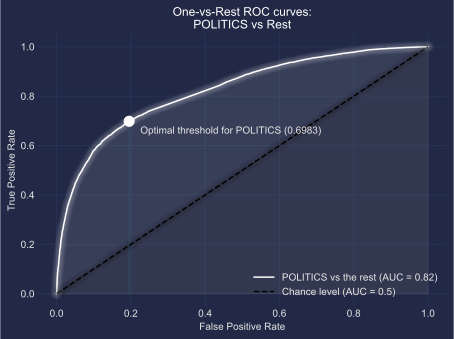

In [109]:
class_of_interest = "POLITICS"
plot_class_roc_curve(
  class_of_interest=class_of_interest,
  Y_one_vs_all=y_onehot_test,
  Y_prob_a=Y_probability_a_td_only,
  df_class_row=df_all_classes_optimal_roc_values.loc[df_all_classes_optimal_roc_values.Class == class_of_interest]
)

##### 4.4.4.6 - Alternative visualizations of the ROC Curve

There are other ways to plot this curve. Here are a few, which might help us understand the "Area Under the Curve" (AUC).

In [110]:
TPR_OPT_MEAN = df_all_classes_optimal_roc_values.drop_duplicates(subset=['Class'])['TPR_Optimal'].mean()
TPR_OPT_MEDIAN = df_all_classes_optimal_roc_values.drop_duplicates(subset=['Class'])['TPR_Optimal'].median()

FPR_OPT_MEAN = df_all_classes_optimal_roc_values.drop_duplicates(subset=['Class'])['FPR_Optimal'].median()
FPR_OPT_MEDIAN = df_all_classes_optimal_roc_values.drop_duplicates(subset=['Class'])['FPR_Optimal'].median()

print(
  'TPR/FPR - Estimates of Location',
  '\n----------------------------',
  '\nTPR_OPT_MEAN:',TPR_OPT_MEAN,
  '\nTPR_OPT_MEDIAN:',TPR_OPT_MEDIAN,
  '\n\nFPR_OPT_MEAN:',FPR_OPT_MEAN,
  '\nFPR_OPT_MEDIAN:',FPR_OPT_MEDIAN,
)

TPR/FPR - Estimates of Location 
---------------------------- 
TPR_OPT_MEAN: 0.7111387096774193 
TPR_OPT_MEDIAN: 0.7308 

FPR_OPT_MEAN: 0.2805 
FPR_OPT_MEDIAN: 0.2805


<Axes: title={'center': 'Optimal TP & FP Rates Per Class \n(TPR mean avg 0.7111387096774193, FPR mean avg 0.2805)'}, xlabel='Class'>

<Figure size 640x480 with 0 Axes>

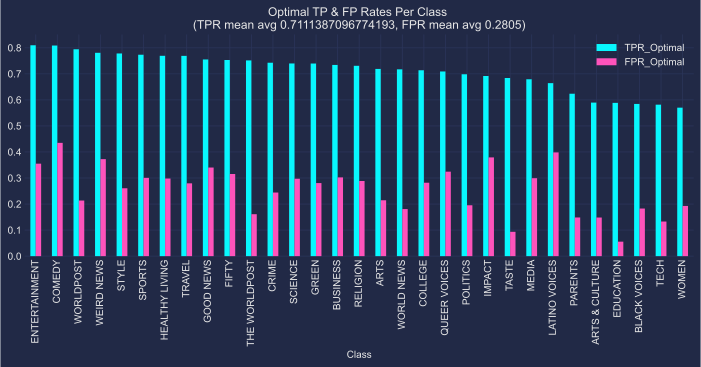

In [111]:
plt.figure()

df_all_classes_optimal_roc_values.sort_values(by='TPR_Optimal', ascending=False).plot(
  kind='bar',
  x='Class',
  y=['TPR_Optimal','FPR_Optimal'],
  figsize=(12,4),
  title='Optimal TP & FP Rates Per Class \n(TPR mean avg '+str(TPR_OPT_MEAN)+', FPR mean avg '+str(FPR_OPT_MEAN)+')'
)

You could use the above bar chart to compare class label performances in relationship to the mean/median optimal threshold rates.

#### 4.4.5 `text_desc` only & count-based modeling assessment

- **Accuracy**: 0.5955581157194061
- **MRR**: 0.47845728793311004
- Bias towards "POLITICS"
  - I believe this happens because most of the data used to train our model is of genre "POLITICS".
- Accuracy and MRR values disappoint. 
  - These values are due to the type of modeling assesment. In this case, the count-based modeling assesment makes model to have low Accuracy and MRR values. 
- ...

### 4.5 Model 2 - `tfidf` features with `text_desc_headline` - short description + headline

In [112]:
field='text_desc_headline'
feature_rep='tfidf'
top_k=3

model_tfidf_tdh,transformer_tfidf_tdh,accuracy_tfidf_tdh,mrr_at_k_tfidf_tdh,X_tfidf_tdh_train,X_tfidf_tdh_test,Y_tfidf_tdh_test,Y_tfidf_tdh_train,preds_tfidf_tdh,eval_items_tfidf_tdh = train_model(
  df,
  field=field,
  feature_rep=feature_rep,
  top_k=top_k
)

print(f"\n\nSimple Mean Average Model Accuracy = {accuracy_tfidf_tdh}\nMean Reciprocal Rank = {mrr_at_k_tfidf_tdh}\n")

2023-11-16 23:27:52,561 : INFO : Starting model training...
2023-11-16 23:27:52,587 : INFO : Extracting features and creating vocabulary...
2023-11-16 23:27:54,529 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-11-16 23:28:33,358 : INFO : Starting evaluation...
2023-11-16 23:28:33,387 : INFO : Done training and evaluation.




Simple Mean Average Model Accuracy = 0.8359254992319508
Mean Reciprocal Rank = 0.7172192353643873



#### 4.5.5 `text_desc`, `headline`, & TF-IDF-based modeling assessment

Now, use the same assessment techniques as in the `text_desc` only model to assess this model that uses TF-IDF + a combination of the short description and headline values as features for the model.

Write your observations and evidence below.

- **Accuracy**: 0.8359254992319508
- **MRR**: 0.7172192353643873
- More Data gives better results. 
  - I think this is due to the increment of data used to train the model. In this case, 'headline' has been added to 'description' which add more data to be trained and thus a better prediction as well. 
- Accuracy and MRR have incremented
  - I believe this is due to the type of modeling assesment used. In this case, the TF-IDF-based modeling assesment is used which gives better accuracy and MRR values. 
- ...

### 4.6 Model 3 - `tfidf` features with `text_desc_headline_url`: description, headline, *and* url

In [113]:
field='text_desc_headline_url'
feature_rep='tfidf'
top_k=3

model_tfidf_all,transformer_tfidf_all,accuracy_tfidf_all,mrr_at_k_tfidf_all,X_tfidf_all_train,X_tfidf_all_test,Y_tfidf_all_test,Y_tfidf_all_train,preds_tfidf_all,eval_items_tfidf_all = train_model(
  df,
  field=field,
  feature_rep=feature_rep,
  top_k=top_k
)

print("\nAccuracy={0}; MRR={1}".format(accuracy_tfidf_all,mrr_at_k_tfidf_all))

2023-11-16 23:28:33,451 : INFO : Starting model training...
2023-11-16 23:28:33,477 : INFO : Extracting features and creating vocabulary...
2023-11-16 23:28:36,173 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-11-16 23:29:28,462 : INFO : Starting evaluation...
2023-11-16 23:29:28,483 : INFO : Done training and evaluation.



Accuracy=0.8672875064004096; MRR=0.7511680747567727


#### 4.6.5 `text_desc`, `headline`, `URL`, & TF-IDF-based modeling assessment

Now, use the same assessment techniques as the previous models to assess this third model that uses TF-IDF + a combination of the short description, headline, and URL values as features for the model.

Write your observations and evidence below.

- **Accuracy**: 0.8672875064004096
- **MRR**: 0.7511680747567727
- More data gives better results
  - The TF-IDF-based modeling assesment is used in this case too, however the accuracy and MRR values have incremented by a bit. The only thing that have changed is the data used to train the model. This makes me assume that more data gives better results.
- TF-IDF-based modeling assessment good for training models. 
  - The same modeling evaluation is used and the results, such as accuracy and MRR values, are still considerably good. 
- ...

## 5. Check Predictions on Unseen Articles

Try from articles that aren't from HuffPost: CNN, Fox, MSNBC, etc.

Remember that the algorithm will return the top `k` probabilities. I've created a default of 3 for `k`. The first value in the list is the top returned predicted value.

### 5.1 Model 1 trained by counts method &amp; the features from the short description only

This uses Model 1: 

- Model: `model_td_only`
- Transformer: `transformer_td_only`

In [114]:
# https://www.cnn.com/2019/07/19/health/astronaut-exercise-iv-faint-scn/index.html
test_features = transformer_td_only.transform(["Exercise in space keeps astronauts from fainting when they return to Earth, study says."])
get_top_k_predictions(
  model_td_only, 
  test_features,
  3
)

[['SCIENCE', 'WOMEN', 'GREEN']]

### 5.2 Model 2 trained by TF-IDF &amp; the features from the short description &amp; headline

This uses Model 2:

- Model: `model_tfidf_tdh`
- Transformer: `transformer_tfidf_tdh`

In [119]:
# URL: https://www.washingtonpost.com/world/2023/11/16/israel-gaza-shifa-hamas-evidence/

test_features=transformer_tfidf_tdh.transform(
    [
     "Israeli troops scour Gaza’s al-Shifa Hospital for evidence of Hamas"
    ]
)

get_top_k_predictions(
  model_tfidf_tdh,
  test_features,
  3
)

[['WORLDPOST', 'POLITICS', 'WORLD NEWS']]

### 5.3 Model 3 trained by TF-IDF &amp; the features from the short description, headline &amp; URL

This uses Model 3:

- Model: `model_tfidf_all`
- Transformer: `transformer_tfidf_all`

In [120]:
# URL: https://www.nytimes.com/2022/12/18/sports/soccer/messi-world-cup-win.html
test_features=transformer_tfidf_tdh.transform(
    [
     "For Messi, and Argentina, the (Extra) Wait Is Worth It"
    ]
)

get_top_k_predictions(
  model_tfidf_tdh,
  test_features,
  3
)

[['SPORTS', 'TASTE', 'ENTERTAINMENT']]

## 6. Save Models for Future Use


In [121]:
# Use imported `pickle` code library

#### 1. COUNTS - 'text_desc' as features only ####
model_path_td_only = "./../models/news_genre_model_binary_text_desc_only.pkl"
transformer_path_td_only = "./../models/news_genre_transformer_binary_text_desc_only.pkl"
# Save both the transformer -> to encode a document and the model itself to make predictions based on the weight vectors 
pickle.dump( model_td_only, open(model_path_td_only, 'wb') )
pickle.dump( transformer_td_only, open(transformer_path_td_only,'wb') )

#### 2. TF-IDF - 'text_desc_headline' as features ####
model_path_tdh = "./../models/news_genre_model_tfidf_tdh.pkl"
transformer_path_tdh = "./../models/news_genre_transformer_tfidf_tdh.pkl"
# Save both the transformer -> to encode a document and the model itself to make predictions based on the weight vectors 
pickle.dump( model_tfidf_tdh, open(model_path_tdh, 'wb') )
pickle.dump( transformer_tfidf_tdh, open(transformer_path_tdh,'wb') )

#### 3. TF-IDF - 'text_desc_headline_url' as features ####
model_path_all = "./../models/news_genre_model_tfidf_all.pkl"
transformer_path_all = "./../models/news_genre_transformer_tfidf_all.pkl"
# Save both the transformer -> to encode a document and the model itself to make predictions based on the weight vectors 
pickle.dump( model_tfidf_all, open(model_path_all, 'wb') )
pickle.dump( transformer_tfidf_all, open(transformer_path_all,'wb') )


## 7. Use Loaded Model

With pickle, we can now also load the model and use it without needing to retrain everything. A good time saver to consider for your team's final project!

In [122]:
# Load Model 2 for reference
# Note my variable assignments include "loaded_" so I can distinguish variable assignments, if necessary.

model_path_tdh = "./../models/news_genre_model_tfidf_tdh.pkl"
transformer_path_tdh = "./../models/news_genre_transformer_tfidf_tdh.pkl"

loaded_model_tfidf_tdh = pickle.load(open(model_path_tdh, 'rb'))
loaded_transformer_tfidf_tdh = pickle.load(open(transformer_path_tdh, 'rb'))

# URL: https://www.nytimes.com/2023/03/12/movies/oscars-slap-will-smith-chris-rock.html
loaded_test_features_tfidf_tdh = loaded_transformer_tfidf_tdh.transform(["How the Slap Has Changed the Oscars"])
get_top_k_predictions(loaded_model_tfidf_tdh, loaded_test_features_tfidf_tdh, 3)


[['ENTERTAINMENT', 'STYLE', 'POLITICS']]

## Conclusion

Overall, do your best to have understood this LR modeling/training process: the goals for the model in relationship to the original data set used. By documenting your observations and using Python to conduct EDA + model assessments, you can complete the following work that you will need to repeat for your final project:

1. Identify potential boundaries, biases, and limits of the data in relationship to your developing and changing goals for modeling
2. Conversely, identify potential possibilities and affordances of the data in relationship to your developing and changing goals for modeling
3. Documenting these biases, affrodances, and changes in goals
4. Use this notebook material to develop a Model Card that communicates the aforementioned material in a more concise and helpful manner.

Note that there is a next step that folks would take next, based on their analysis to "tune" their model. We won't get to that part of the process in this class. Instead, we are focusing on the initial training step, the impact of different features available to use in the data set, and assessing the initial training based on the data.